In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fcsparser
import os

In [2]:
files_concs = {
"export_Specimen_001_B1_B01_FITCpos.fcs": 0,
"export_Specimen_001_B2_B02_FITCpos.fcs": 0.0001,
"export_Specimen_001_B3_B03_FITCpos.fcs": 0.000599,
"export_Specimen_001_B4_B04_FITCpos.fcs": 0.00359,
"export_Specimen_001_B5_B05_FITCpos.fcs": 0.0215,
"export_Specimen_001_B6_B06_FITCpos.fcs": 0.129,
"export_Specimen_001_B7_B07_FITCpos.fcs": 0.773,
"export_Specimen_001_B8_B08_FITCpos.fcs": 4.46,
"export_Specimen_001_B9_B09_FITCpos.fcs": 26.8,
"export_Specimen_001_B10_B10_FITCpos.fcs": 119,
"export_Specimen_001_B11_B11_FITCpos.fcs": 714,
}

In [3]:
fcs_df = pd.DataFrame()

for file, concentration in files_concs.items():
    file_path = os.path.expanduser(f"~/Downloads/Archive/" + file)
    meta, fcs = fcsparser.parse(file_path, reformat_meta=True)
    spill_values = meta["$SPILLOVER"].split(',')
    n_ch = int(spill_values[0])
    spill_df = pd.DataFrame(np.array(spill_values[(n_ch + 1):], dtype=np.float64).reshape((n_ch, n_ch)).T,
                            index=spill_values[1:(n_ch + 1)])
    fcs[spill_df.index] = np.linalg.solve(spill_df, fcs[spill_df.index].T).T
    fcs["sample"] = file[:-4]
    fcs["concentration"] = concentration * 1e-9
    fcs_df = pd.concat(
        (fcs_df,
            fcs[["sample",
                 "concentration",
                 "PE-A",
                ]
               ]
               ),
        ignore_index=True)
    
fcs_df

,sample,concentration,PE-A
0,export_Specimen_001_B1_B01_FITCpos,0.000000e+00,16.275512
1,export_Specimen_001_B1_B01_FITCpos,0.000000e+00,55.862926
2,export_Specimen_001_B1_B01_FITCpos,0.000000e+00,-47.228010
3,export_Specimen_001_B1_B01_FITCpos,0.000000e+00,20.287592
4,export_Specimen_001_B1_B01_FITCpos,0.000000e+00,120.065172
...,...,...,...
14746,export_Specimen_001_B11_B11_FITCpos,7.140000e-07,27453.816375
14747,export_Specimen_001_B11_B11_FITCpos,7.140000e-07,56218.604200
14748,export_Specimen_001_B11_B11_FITCpos,7.140000e-07,35182.267343
14749,export_Specimen_001_B11_B11_FITCpos,7.140000e-07,148267.080831


In [4]:
fcs_df.shape

(14751, 3)

Channel spillover matrix (we invert this to correct for spillover)

In [5]:
spill_df

,0,1
FITC-A,1.000000,0.00334
PE-A,0.000168,1.00000


/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/seaborn/categorical.py:871: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x, y, **{**flier_colors, "s": 25, **flier_kws})


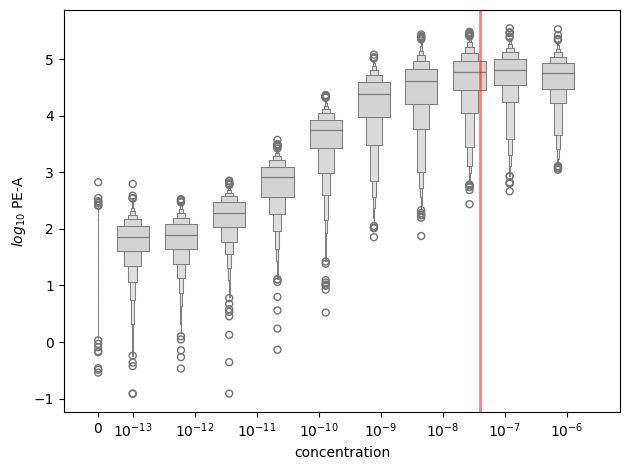

In [18]:
fcs_df["$log_{10}$ PE-A"] = np.log10(fcs_df["PE-A"])

sns.boxenplot(data=fcs_df,
            x="concentration",
            y="$log_{10}$ PE-A",
            native_scale=True,
            log_scale=(True, False),
            color="lightgrey",
            # k_depth="proportion",
            # outlier_prop=0.1,
            # inner="quart",
            # density_norm="width",
            )
plt.axvline(40e-9, color="r", linestyle='-', lw=2, alpha=0.5, label="BLI naive $K_D$")
plt.xscale("symlog", linthresh=1e-13, linscale=0.5)
plt.xlim(-1e-13, fcs_df.concentration.max() * 10)
plt.tight_layout()
plt.show()

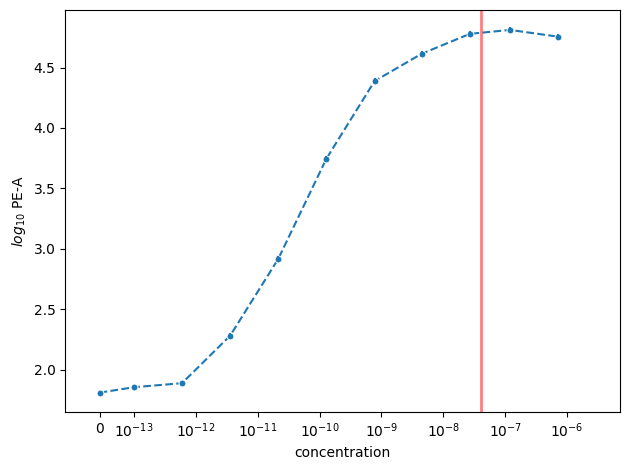

In [16]:
sns.lineplot(data=fcs_df,
            x="concentration",
            y="$log_{10}$ PE-A",
            estimator="median",
            marker="o",
            ms=5,
            ls="--",
            errorbar="se",
            err_style="bars",
            )
plt.axvline(40e-9, color="r", linestyle='-', lw=2, label="BLI naive $K_D$", alpha=0.5)
plt.xscale("symlog", linthresh=1e-13, linscale=0.5)
plt.xlim(-1e-13, fcs_df.concentration.max() * 10)
plt.tight_layout()
plt.show()

Fraction of non-positive fluorescence values

In [10]:
(fcs_df["PE-A"] <= 0).sum() / fcs_df.shape[0]

0.039048200122025624

In [11]:
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax
from jax.scipy.special import expit
import jaxopt

In [12]:
def hill(logx, logKd, n):
    result = jnp.zeros_like(logx).at[1:].set(
        jax.scipy.special.expit(
            n * (logx[1:] - logKd)
        )
    )
    return result

def f(loga, logb, logKd, n, logx):
    return jnp.exp(loga) * hill(logx, logKd, n) + jnp.exp(logb)

We model the PE-A channel as log-Gaussian (dropping negative values)

In [13]:
@jax.jit
@jax.value_and_grad
def logf_loghill_loss(params, logx, logy, delta=1.0):
    loga, logb, logKd, n = params
    logf_mean = jnp.log(f(loga, logb, logKd, n, logx))
    return jaxopt.loss.huber_loss(logy, logf_mean, delta=delta).mean()

@jax.jit
@jax.value_and_grad
def logf_hill_loss(params, logx, logy, delta=1.0):
    loga, logb, logKd, n = params
    logf_mean = f(loga, logb, logKd, n, logx)
    return jaxopt.loss.huber_loss(logy, logf_mean, delta=delta).mean()

In [14]:
opt_loghill = jaxopt.NonlinearCG(
                logf_loghill_loss,
                value_and_grad=True,
                maxiter=2000, tol=0,
                maxls=100, linesearch="backtracking",
                # verbose=True,
)

opt_hill = jaxopt.NonlinearCG(
                logf_hill_loss,
                value_and_grad=True,
                maxiter=2000, tol=0,
                maxls=100, linesearch="backtracking",
                # verbose=True,
)

In [15]:
loga = 10.0
logb = 4.0
logKd = -20.0
n = 1.0
params0 = jnp.array([loga, logb, logKd, n])

# x = fcs_df.concentration.values
# logx = np.log(x)

x = np.asarray(list(files_concs.values())) * 1e-9
logx = np.log(x)

y = fcs_df.groupby("concentration")["PE-A"].median().values
logy = np.log(y)

positive_idxs = y > 0
x = x[positive_idxs]
logx = logx[positive_idxs]
y = y[positive_idxs]
logy = logy[positive_idxs]

logf_loghill_loss(params0, logx, logy)

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_52218/817197334.py:11: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)


(Array(0.43277715, dtype=float64),
 Array([-0.63647969, -0.0887393 ,  0.28490315,  0.75692455], dtype=float64))

In [16]:
delta = 0.5

params_loghill, state = opt_loghill.run(params0, logx[positive_idxs], logy[positive_idxs], delta=delta)
display(state)

NonlinearCGState(iter_num=Array(2000, dtype=int64, weak_type=True), stepsize=Array(2.54629497e-10, dtype=float64), error=Array(3.92035246e-09, dtype=float64), value=Array(0.00261255, dtype=float64), grad=Array([ 2.34170821e-10, -5.27351251e-10,  3.67241965e-09,  1.24481404e-09],      dtype=float64), descent_direction=Array([-2.34170821e-10,  5.27351251e-10, -3.67241965e-09, -1.24481404e-09],      dtype=float64), aux=None, num_fun_eval=Array(118813, dtype=int32), num_grad_eval=Array(118813, dtype=int32), num_linesearch_iter=Array(118812, dtype=int32))

In [17]:
loga = 2.0
logb = 1.5
logKd = -25.0
params0 = jnp.array([loga, logb, logKd, n])

params_hill, state = opt_hill.run(params0, logx[positive_idxs], logy[positive_idxs], delta=delta)
display(state)

NonlinearCGState(iter_num=Array(2000, dtype=int64, weak_type=True), stepsize=Array(0.04704564, dtype=float64), error=Array(1.02236052e-07, dtype=float64), value=Array(0.00241199, dtype=float64), grad=Array([ 5.39796491e-08,  3.76630682e-08, -3.55646775e-08,  4.30661418e-09],      dtype=float64), descent_direction=Array([-5.39796483e-08, -3.76630675e-08,  3.55646778e-08, -4.30661409e-09],      dtype=float64), aux=None, num_fun_eval=Array(3648, dtype=int32), num_grad_eval=Array(3648, dtype=int32), num_linesearch_iter=Array(3647, dtype=int32))

In [18]:
b = np.array([-288., 136., 2000., 29421., 262143.])
c = np.array([1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 0])

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_52218/1008403721.py:2: RuntimeWarning: divide by zero encountered in log
  logx_grid = np.log(x_grid)


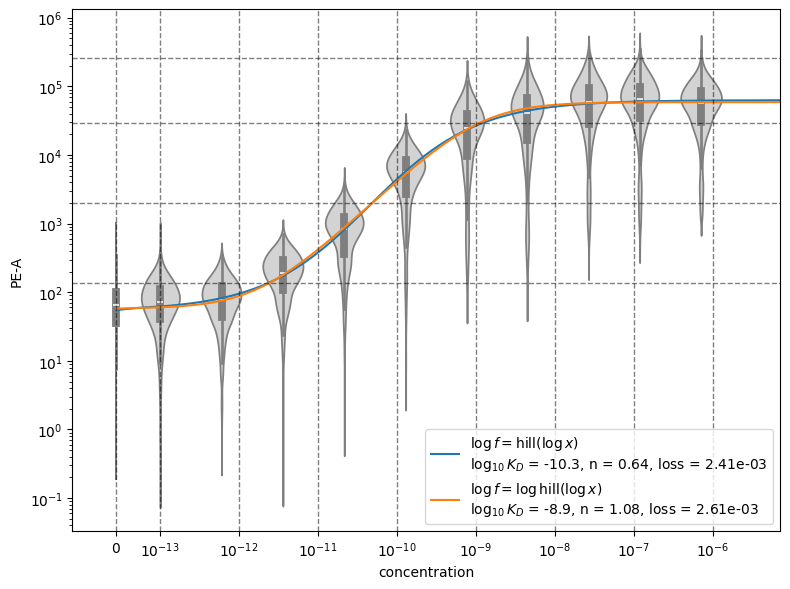

In [19]:
x_grid = np.asarray([0] + np.logspace(-14, -5, 100).tolist())
logx_grid = np.log(x_grid)

plt.figure(figsize=(8, 6))
sns.violinplot(data=fcs_df,
            x="concentration",
            y="PE-A",
            native_scale=True,
            log_scale=(True, True),
            color="lightgrey",
            # k_depth="proportion",
            # outlier_prop=0.1,
            # inner="quart",
            # density_norm="width",
            )
# plt.plot(x, f(*params0, n, logx), label="initial guess")
plt.plot(x_grid, np.exp(f(*params_hill, logx_grid)),
         label=f"$\log f = \mathrm{{hill}}(\log x)$\n$\log_{{10}}K_D$ = {params_hill[2] / np.log(10):.1f}, n = {params_hill[3]:.2f}, loss = {logf_hill_loss(params_hill, logx[positive_idxs], logy[positive_idxs], delta=delta)[0]:.2e}",
         )
plt.plot(x_grid, f(*params_loghill, logx_grid),
         label=f"$\log f = \log\mathrm{{hill}}(\log x)$\n$\log_{{10}}K_D$ = {params_loghill[2] / np.log(10):.1f}, n = {params_loghill[3]:.2f}, loss = {logf_loghill_loss(params_loghill, logx[positive_idxs], logy[positive_idxs], delta=delta)[0]:.2e}",
         )
for bi in b:
    plt.axhline(bi, color="k", linestyle='--', lw=1, alpha=0.5)
for ci in c:
    plt.axvline(ci, color="k", linestyle='--', lw=1, alpha=0.5)
plt.xscale("symlog", linthresh=1e-13, linscale=0.5)
# plt.yscale("symlog")
plt.xlim(-1e-13, fcs_df.concentration.max() * 10)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
params_hill, params_loghill

(Array([  1.95461408,   1.38374715, -23.82122272,   0.63957251], dtype=float64),
 Array([ 10.98388992,   4.0575771 , -20.60516998,   1.0765185 ], dtype=float64))

## Effective $K_D$ for Hill model on log-fluorescence

If fluorescence has a Hill response, the log-fluorescence is of the form
$$
\log f(x) = \log \left(a \left(\frac{x}{x + K_D}\right) + b \right).
$$
The concentration $x'$ at which the log-fluorescence change is half-maximal is given by
$$
\begin{align*}
\log \left(a \left(\frac{x'}{x' + K_D}\right) + b \right) - \log b &= \frac{\log (a + b) - \log b}{2}\\
\log \left(\frac{a}{b} \left(\frac{x'}{x' + K_D}\right) + 1 \right) &= \frac{\log (\frac{a}{b} + 1)}{2}\\
\frac{x'}{x' + K_D} &= \frac{b}{a}\left(\exp\left(\frac{\log (\frac{a}{b} + 1)}{2}\right) - 1\right)\\
x' &= \frac{K_D}{\sqrt{1+\frac{a}{b}}}
\end{align*}
$$
Now, we typically have $a \gg b$, so, to lowest order in $b/a$, we have
$$
\begin{align*}
x' &\simeq \sqrt{\frac{b}{a}}K_D\\
\log x' &\simeq \log K_D - \frac{1}{2}(\log a - \log b)\\
\log K_D &\simeq \log x' + \frac{1}{2}(\log a - \log b)\\
\log_{10} K_D &\simeq \log_{10} x' + \frac{1}{2}(\log_{10} a - \log_{10} b)\\
\end{align*}
$$
This amounts to a true $\log_{10}K_D$ that is shifted up from half-max concentration by $\frac{1}{2}(\log_{10} a - \log_{10} b)$.

Predicted affinity shift:

In [18]:
(params_loghill[1] - params_loghill[0]) / 2 / np.log(10)

Array(-1.50402972, dtype=float64)

Observed affinity shift:

In [19]:
(params_hill[2] - params_loghill[2]) / np.log(10)

Array(-1.39671396, dtype=float64)

## Effective $n$ for Hill model on log-fluorescence

As above, if fluorescence has a Hill response, the log-fluorescence is of the form
$$
\log f(x) = \log \left(a \left(\frac{x}{x + K_D}\right) + b \right).
$$
We now derive the apparent Hill coefficient $n$ that would be observed if we fit a Hill model to the log-fluorescence.
The slope at half-maximal concentration change is given by $\partial_{\log x}\log f(x)\bigg\rvert_{x=x'}$, where $x'$ is the concentration at which the log-fluorescence change is half-maximal, as derived above.
$$
\begin{align*}
\partial_{\log x}\log f(x)\bigg\rvert_{x=x'} &= \partial_u \log f(e^u)\bigg\rvert_{u=\log x'}\\
&= \frac{\partial_u f(e^u)}{f(e^u)}\bigg\rvert_{u=\log x'}\\
&\quad\vdots\\
&\simeq 1 - 2\sqrt{\frac{b}{a}}
\end{align*}
$$
where again we've assumed $a \gg b$ and taken the leading order term.

The slope at half-max for the non-log fluorescence model is $\frac{\tilde{a} n}{4}$, where $\tilde{a} = \log\left(a + b\right) - \log b$ is the max log-fluorescence parameter in that model.
The predicted effective Hill coefficient is obtained by setting the slopes of the two models equal at half-max log-fluorescence:
$$
n = \left(\frac{4}{\log\left(a + b\right) - \log b}\right)\left(1 - 2\sqrt{\frac{b}{a}}\right)
$$


In [20]:
(4 / (np.logaddexp(params_loghill[0], params_loghill[1]) - params_loghill[1])) * (1 - 2 * np.sqrt(np.exp(params_loghill[1] - params_loghill[0])))

Array(0.54124371, dtype=float64)

This is a decent match to the fitted $n$ for the non-log model.